In [1]:
import torch
import torch.nn as nn

In [2]:
import numpy as np

In autoregressive tasks (e.g., language modeling), when predicting the next token at position $i$, the model should only use information from tokens at positions $1$ to $i$ (previous and current tokens). Allowing token $i$ to attend to tokens at positions $j > i$ (future tokens) would leak future information, which is invalid for tasks where tokens are generated sequentially.

Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores.

The causal mask ensures that token $i$ only attends to tokens $j$ where $j <= i$

For each token processed, we mask out the future tokens, which come after the current token in the input text.
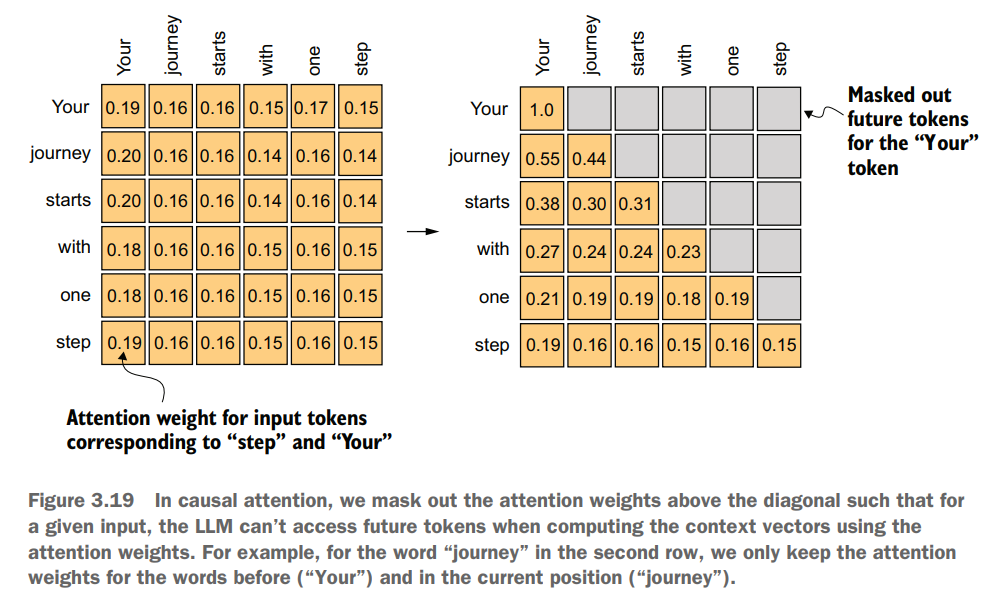

In [3]:
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias = False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        d_k = keys.shape[-1]
        attn_weights = torch.softmax(attn_scores/np.sqrt(d_k), dim = -1)
        context_vec = attn_weights @ values
        return context_vec

sa = SelfAttention_v2(d_in=3, d_out=2)

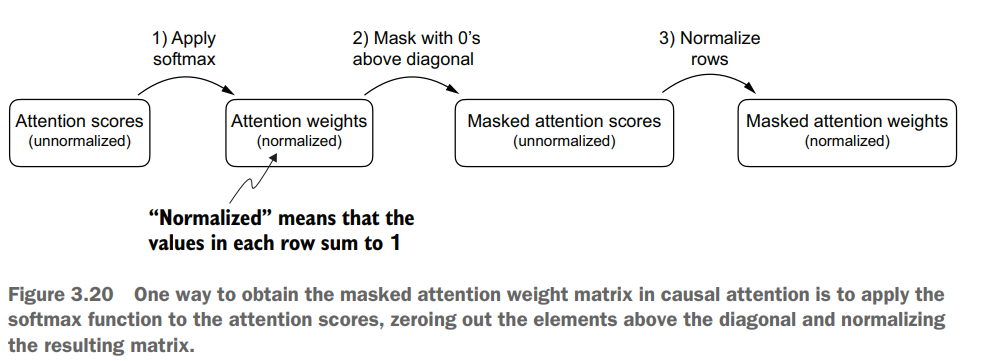

### Step 1: Get attention weights

In [4]:
queries = sa.W_query(inputs)
keys = sa.W_key(inputs)
attn_scores = queries @ keys.T
d_k = keys.shape[-1]
attn_weights = torch.softmax(attn_scores/np.sqrt(d_k), dim = -1)
print(attn_weights)

tensor([[0.1808, 0.1635, 0.1650, 0.1553, 0.1928, 0.1427],
        [0.1786, 0.1737, 0.1739, 0.1535, 0.1670, 0.1532],
        [0.1781, 0.1732, 0.1734, 0.1542, 0.1676, 0.1536],
        [0.1733, 0.1732, 0.1731, 0.1581, 0.1615, 0.1609],
        [0.1654, 0.1610, 0.1615, 0.1703, 0.1777, 0.1641],
        [0.1787, 0.1790, 0.1786, 0.1510, 0.1564, 0.1563]],
       grad_fn=<SoftmaxBackward0>)


### Step 2: Create mask and apply it

In [5]:
context_length = attn_weights.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [6]:
masked_simple = attn_weights * mask_simple
print(masked_simple)

# # OR simply:
# masked_simple = torch.tril(attn_weights)
# # torch.tril extracts the lower triangular part

tensor([[0.1808, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1786, 0.1737, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1781, 0.1732, 0.1734, 0.0000, 0.0000, 0.0000],
        [0.1733, 0.1732, 0.1731, 0.1581, 0.0000, 0.0000],
        [0.1654, 0.1610, 0.1615, 0.1703, 0.1777, 0.0000],
        [0.1787, 0.1790, 0.1786, 0.1510, 0.1564, 0.1563]],
       grad_fn=<MulBackward0>)


### Step 3: Re-normalize the attention weights row wise

In [7]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5069, 0.4931, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3394, 0.3301, 0.3305, 0.0000, 0.0000, 0.0000],
        [0.2557, 0.2557, 0.2554, 0.2333, 0.0000, 0.0000],
        [0.1979, 0.1926, 0.1932, 0.2037, 0.2126, 0.0000],
        [0.1787, 0.1790, 0.1786, 0.1510, 0.1564, 0.1563]],
       grad_fn=<DivBackward0>)


### Problem with this method - Information Leakage
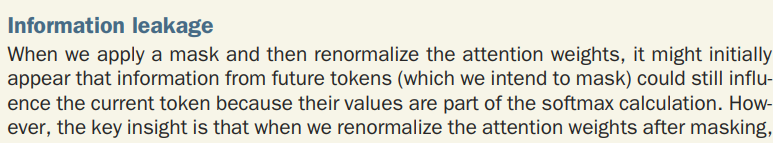
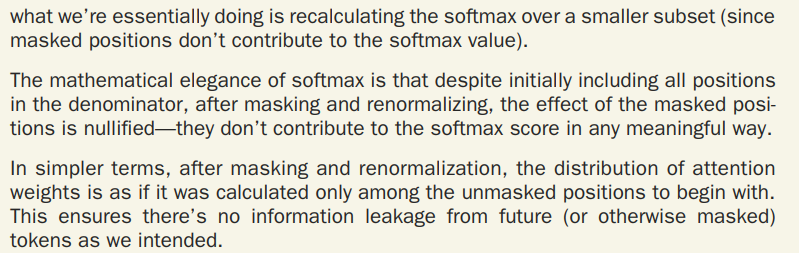

### More efficient way
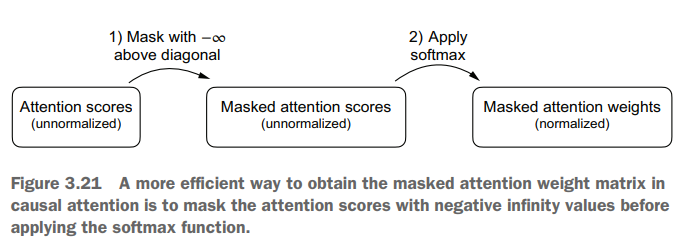

In [8]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(mask.bool())
print(masked)


tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])
tensor([[ 0.1676,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.3481,  0.3091,    -inf,    -inf,    -inf,    -inf],
        [ 0.3269,  0.2873,  0.2892,    -inf,    -inf,    -inf],
        [ 0.2526,  0.2523,  0.2508,  0.1227,    -inf,    -inf],
        [-0.1476, -0.1860, -0.1813, -0.1067, -0.0463,    -inf],
        [ 0.4680,  0.4705,  0.4673,  0.2300,  0.2794,  0.2790]],
       grad_fn=<MaskedFillBackward0>)


In [9]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5069, 0.4931, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3394, 0.3301, 0.3305, 0.0000, 0.0000, 0.0000],
        [0.2557, 0.2557, 0.2554, 0.2333, 0.0000, 0.0000],
        [0.1979, 0.1926, 0.1932, 0.2037, 0.2126, 0.0000],
        [0.1787, 0.1790, 0.1786, 0.1510, 0.1564, 0.1563]],
       grad_fn=<SoftmaxBackward0>)


When negative infinity values $-\infty$ are present in a row, the softmax function treats them as zero
probability. (Mathematically, this is because $e^{–\infty}$ approaches $0$.)

## Masking additional attention weights with dropout
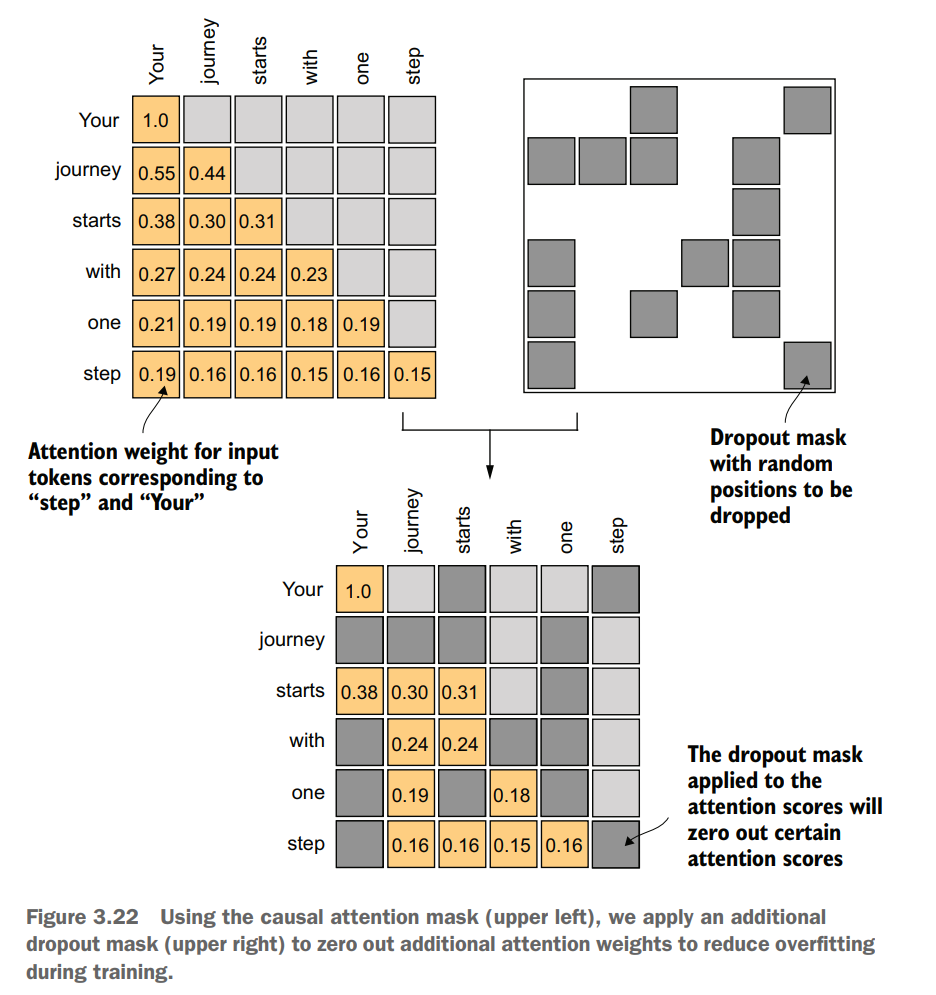

When applying dropout to an attention weight matrix with a rate of $50\%$, half of the elements in the matrix are randomly set to zero. To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of $1/0.5 = 2$. This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases

In [10]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) 
example = torch.ones(6, 6) 
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [11]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9862, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6610, 0.0000, 0.0000, 0.0000],
        [0.5114, 0.5113, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3580, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


## Coding the Causal Attention class

Let’s ensure that the code can handle batches consisting of more than one input so that the `CausalAttention` class supports the batch outputs produced by the data loader we implemented in chapter $2$.

In [12]:
# Stacking inputs to simulate a batch
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [13]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [28]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()

        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout)

        self.register_buffer('mask',
                             torch.triu(torch.ones(context_length, context_length), diagonal=1)
                            )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        # Transposing each key so that matrix multiplication is possible. For each instance of a batch we transpose, so no need to include the batch dimension
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        
        # attn_weights = torch.softmax(attn_scores / self.d_out ** 0.5, dim= -1)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim= -1)
        
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        return context_vec

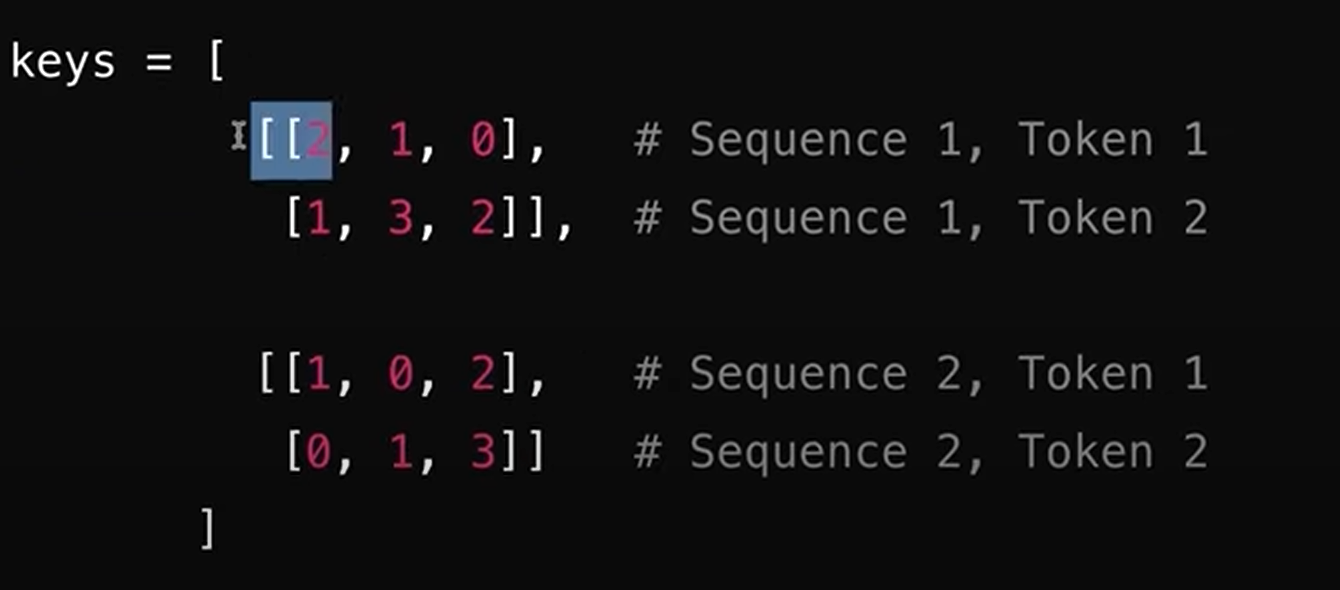
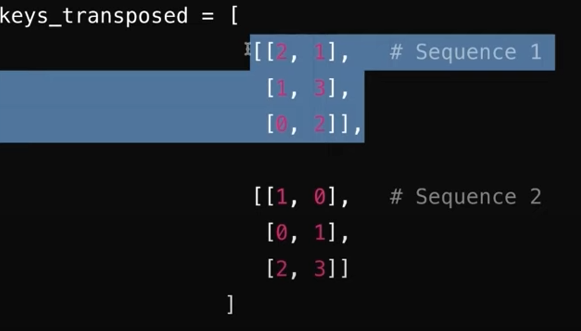

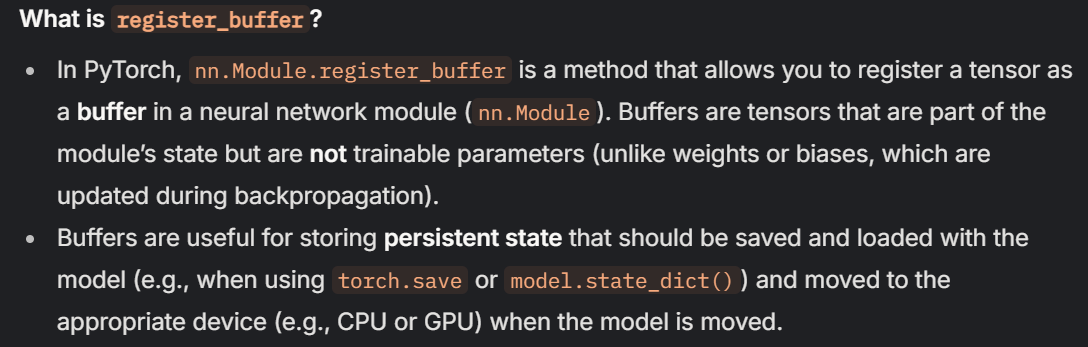
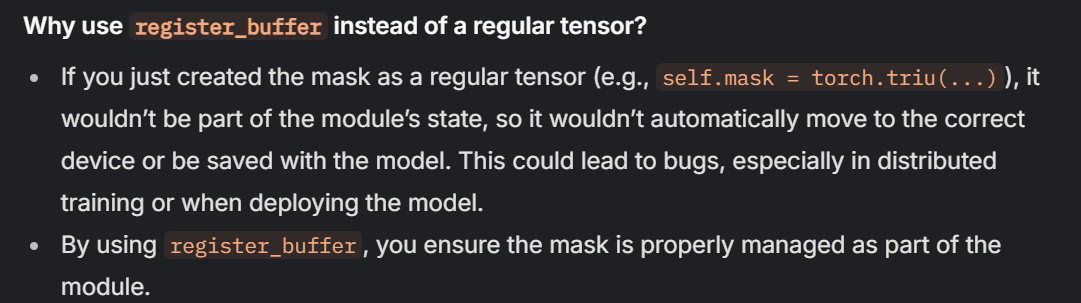


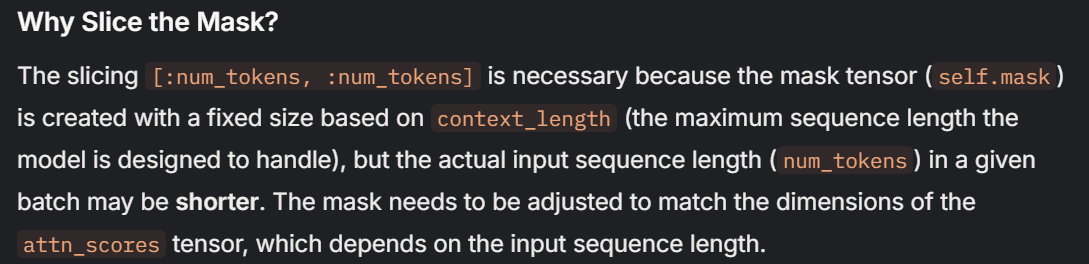
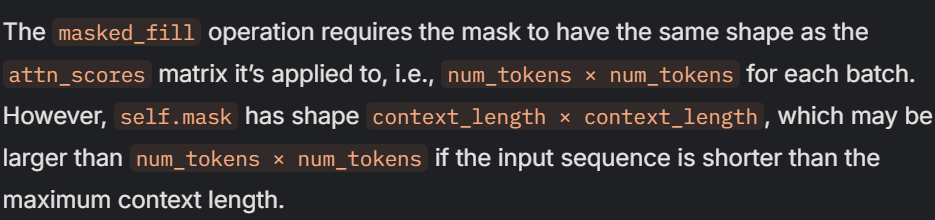

In [30]:
torch.manual_seed(123)
d_in = 3
d_out = 2
context_length = batch.shape[1]
ca1 = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca1(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [31]:
print(context_vecs)

tensor([[[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]],

        [[-0.5337, -0.1051],
         [-0.5323, -0.1080],
         [-0.5323, -0.1079],
         [-0.5297, -0.1076],
         [-0.5311, -0.1066],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


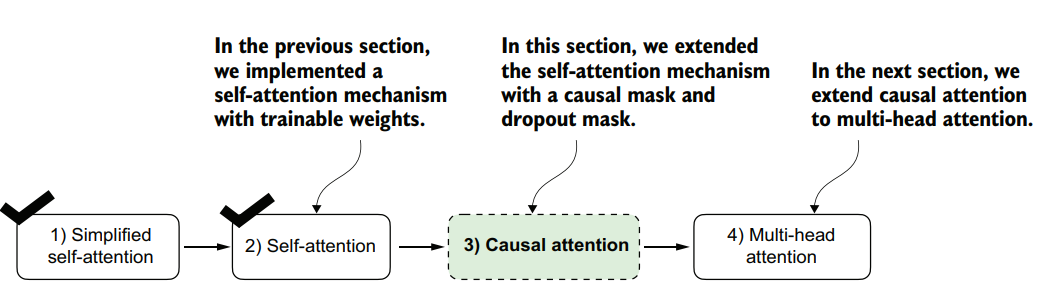